# **<center>Livrable 2</center>**
<center>Quentin Trappier – Hugo Durupt – Enzo Marcelli – Fabien Arrighi</center>

___

# I. Introduction

Avec la nécessité de prendre en compte l'écologie, des mesures sont à prendre afin d'optimiser les processus de livraison. Nous représentons une entreprise nommée CesiCDP dont l'objectif est de trouver des solutions pour aider à la transition écologique et technologique. L'ADEME propose des financements pour les entreprises proposant des solutions de mobilité plus écologiques et responsable. Il s'agirait pour notre entreprise d'arriver à trouver une solution algorithmique permettant de calculer sur un réseau routier une tournée permettant de relier entre elles un sous-ensemble de villes, puis de revenir à son point de départ, de manière à minimiser la durée totale de la tournée.

<center><img src="img/projet_1.png"/></center>

Le schema ci-dessus montre les routes que nous devons optimiser.

---

# II. Modélisation

## 1. Problème de décision

Pour mieux comprendre le projet et les demandes, nous allons écrire le problème de décision associé aux demandes. Pour ce faire, nous allons avoir besoin de décrire d’abord les données en entrées. 
Les données en entrées sont des données représentant un graphe. Le meilleur moyen de représenter un graphe est la matrice d’adjacence. En effet, nous aurions pu utiliser une liste d’adjacence, mais celle-ci est optimale dans les cas où le graphe est peu dense. Or, dans notre cas, le graphe risque d’être dense, nous priorisons donc une matrice d’adjacence. Cette matrice d’adjacence ``A`` de dimension ``n * n``, où ``n`` est le nombre de sommets du graphe. Chaque élément ``A[i][j]`` indique le poids de l'arête entre les sommets ``i`` et ``j``, avec ``A[i][j] = 0`` si aucune arête n'existe entre ``i`` et ``j``.
Après avoir défini les données, nous allons décrire le problème de décision avec k l'entier défini qui représente le poids total du chemin à ne pas dépasser :

<center style="font-weight:bold;">Existe-t-il un cycle C qui passe par tous les sommets tel que la somme des poids des arêtes de C soit ≤k ?</center>

Nous pouvons trouver un problème d’optimisation, permettant de trouver une solution encore plus optimale :

<center style="font-weight:bold;">Trouver un cycle C qui passe par tous les sommets tel que la somme des poids des arêtes de C soit minimale.</center>

## 2. Classe de complexité

Le problème à résoudre est NP-complet. Pour le prouver, il faut montrer que :

- Le problème se vérifie en temps polynomial.
- Le problème peut être réduit de façon polynomiale à un autre problème. 

Pour prouver que le problème se vérifie en temps polynomial, il faut regarder ce que renverra notre algorithme, et les données en entrée. Le programme retournera une chaîne de caractères ou une liste, représentant le cycle retourné. De plus, le poids total du cycle est retourné, représentant le nombre de kilomètres parcourus pour retourner jusqu’au point de départ.
>Par exemple :
>
>["A", "D", "B", "C", "E", "A"], 15

Ici, on a un cycle qui commence par le point ``A`` puis passe par le ``D`` puis le ``B`` puis le ``E`` et reviens au ``A``. Le poids total (dont la valeur représente des kilomètres), est de 15.
Pour vérifier que le problème est vérifiable en temps polynomial, il faut regarder si ce chemin est un cycle valide. Pour ce faire, nous pouvons parcourir les sommets retournés et vérifier si tel et tel sommet sont bien connectés par une arête grâce aux données en entrée (le graphe). De plus, pendant le parcours de ce cycle, si l’arrête est correcte, on additionne le poids de l’arête a un poids total. Cela permettra de vérifier à la fin du parcours, si en plus de savoir que le cycle est valide, que le poids correspond bien au poids du chemin. Le parcours de cycle dans le cadre de graphe se fait en temps polynomial. La première étape est donc vérifiée.
La deuxième étape consiste à faire une réduction polynomiale de ce problème. Pour ce faire, il faut trouver un autre problème NP-complet. Il se trouve que notre problème s’apparente à un autre problème, le problème du voyageur. En effet, le problème du voyageur consiste à trouver un circuit le plus petit qui passe exactement une fois par chaque ville (représentée par des sommets) et revient au sommet de départ. La seule différence étant que dans notre cas, nous pouvons repasser plusieurs fois sur un sommet, si nécessaire. Par exemple, nous serons forcés de repasser par le sommet de départ (ou ville de départ), car pour atteindre certaines villes, il faut repasser par celle-ci. Le problème reste néanmoins une réduction polynomiale du problème du voyageur.

---

# III. Implémentation et exploitation

### Importation de tous les modules nécessaire pour la suite

In [1]:
import time
import pulp
import copy
import random
import numpy as np
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans
from ipywidgets import IntProgress
from IPython.display import display
from collections import deque

## 1. Modélisation des villes

Pour simuler un problème, nous devons générer un ensemble de coordonnées aléatoires représentant les positions des villes. Nous avons choisi de générer uniquement des coordonnées et aucun lien (arrête) car nous considérons que toutes les villes sont reliées entre elles ce qui nous rapproche au plus de la réalité, car il existe toujours une autoroute, une route de campagne... permettant d'aller d'une ville à une autre sans passer par une ville intermédiaire.<br>
Le nombre de villes, ainsi que les plages de coordonnées pour les axes X et Y, peuvent être ajustés selon les besoins. L'utilisation d'une graine aléatoire permet de reproduire les mêmes ensembles de données.

### 1.1. Création de la classe ``Cities``

Cette classe génère de manière aléatoire (ou non si une seed est donnée) les villes.

In [15]:
class Cities:
    cities = []

    def __init__(self, nb_nodes: int, x_range: tuple[int, int], y_range: tuple[int, int], seed: int=None) -> None:
        """
        Initialize the cities with random coordinates

        :param nb_nodes: Number of cities
        :param x_range: Range of x coordinates
        :param y_range: Range of y coordinates
        :param seed: Seed for random generation
        """
        self.x_range = x_range
        self.y_range = y_range
        if seed:
            random.seed(seed)
        used_coordinates = set()

        while len(self.cities) < nb_nodes:
            x = random.randint(self.x_range[0], self.x_range[1])
            y = random.randint(self.y_range[0], self.y_range[1])

            if (x, y) not in used_coordinates:
                used_coordinates.add((x, y))
                self.cities.append((len(self.cities) + 1, x, y))

    def calculateDistance(self, city_1: int, city_2: int) -> float:
        """
        Calculate the distance between two cities

        :param city_1: Index of the first city
        :param city_2: Index of the second city
        :return: Distance between the two cities
        """
        city_1 = self.cities[city_1 - 1]
        city_2 = self.cities[city_2 - 1]
        return ((city_1[1] - city_2[1])**2 + (city_1[2] - city_2[2])**2)**0.5

    def calculateDistanceFromCenter(self, city: int) -> float:
        """
        Calculate the distance between a city and the center of the map

        :param city: Index of the city
        :return: Distance between the city and the center of the map
        """
        city = self.cities[city - 1]
        return ((city[1] - self.x_range[1]/2)**2 + (city[2] - self.y_range[1]/2)**2)**0.5

    def getCenterCity(self) -> tuple[int, int, int]:
        """
        Get the city closest to the center of the map

        :return: Index of the city closest to the center of the map
        """
        distances = [(point, self.calculateDistanceFromCenter(point[0])) for point in self.cities]
        return min(distances, key=lambda x: x[1])[0]

### 1.2. Création de la classe ``Graph``

Cette classe va nous premettre de visualiser le positionnement des villes ainsi que les trajet ttrouvé par les différents algorithmes.

In [3]:
class Graph:
    def __init__(self, data: tuple[int, int, int], title: str="", xlabel: str="X Coordinate", ylabel: str="Y Coordinate", figsize: tuple[int, int]=(10, 10)) -> None:
        """
        Initialize the graph

        :param data: Data to plot
        :param title: Title of the graph
        :param xlabel: Label of the x-axis
        :param ylabel: Label of the y-axis
        :param figsize: Size of the figure
        """
        self.data = data
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.figsize = figsize

    def scatterPlot(self, **kwargs) -> None:
        """
        Plot the data in a scatter plot

        :param kwargs: Additional arguments for the scatter plot
        """
        plt.figure(figsize=self.figsize)
        second_kwargs = {}
        if kwargs.get("arrow") != None:
            second_kwargs["arrow"] = kwargs["arrow"]
            kwargs.pop("arrow")
        plt.scatter([x[1] for x in self.data], [x[2] for x in self.data], **kwargs)
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        for i, txt in enumerate(self.data):
            plt.annotate(txt[0], (txt[1], txt[2]))
        if second_kwargs.get("arrow") != None:
            num_clusters = len(second_kwargs["arrow"])
            colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))
            for cluster_idx, cycle in enumerate(second_kwargs["arrow"]):
                color = colors[cluster_idx]
                for i in range(len(cycle)):
                    start = cycle[i]
                    end = cycle[(i + 1) % len(cycle)]
                    arrow = patches.FancyArrowPatch((start[1], start[2]), (end[1], end[2]), mutation_scale=20, arrowstyle='-|>', color=color)
                    plt.gca().add_patch(arrow)
        plt.show()

### 1.3. Génération des villes

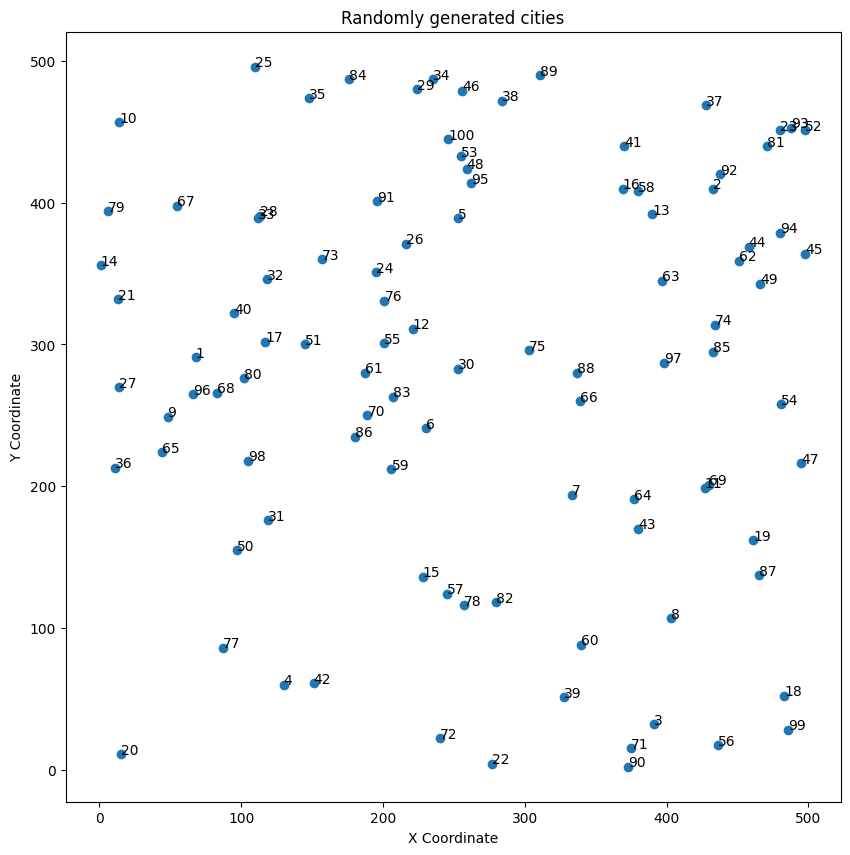

In [4]:
nb_nodes = 100
x_range = (0, 500)
y_range = (0, 500)

data = Cities(nb_nodes, x_range, y_range, 1)

center_city = data.getCenterCity()

graph = Graph(data=data.cities, title="Randomly generated cities")
graph.scatterPlot()

## 2. Clusturing k-means

Le clustering k-means est une méthode visant à diviser un ensemble de données en k groupes distincts, appelés clusters. Le processus débute par la sélection aléatoire de k points initiaux, nommés centroids. Chaque point de données est ensuite assigné au centroid le plus proche, formant ainsi k clusters. Une fois les points assignés, les centroids sont mis à jour en calculant la moyenne des points de chaque cluster. Ce cycle d’assignation et de mise à jour se répète jusqu’à ce que les centroids se stabilisent ou qu’un critère d’arrêt soit atteint.

Dans notre cas, le clustering k-means est employé pour diviser le problème global en plusieurs sous-problèmes plus petits. En regroupant les villes en k clusters basés sur leur proximité géographique, on réduit la complexité du problème initial, rendant chaque sous-problème plus facile à résoudre. Chaque cluster représente un sous-ensemble de villes qui peut être optimisé individuellement avant de combiner les résultats pour obtenir une solution globale.

### Création de la classe ``kMeansClusters``

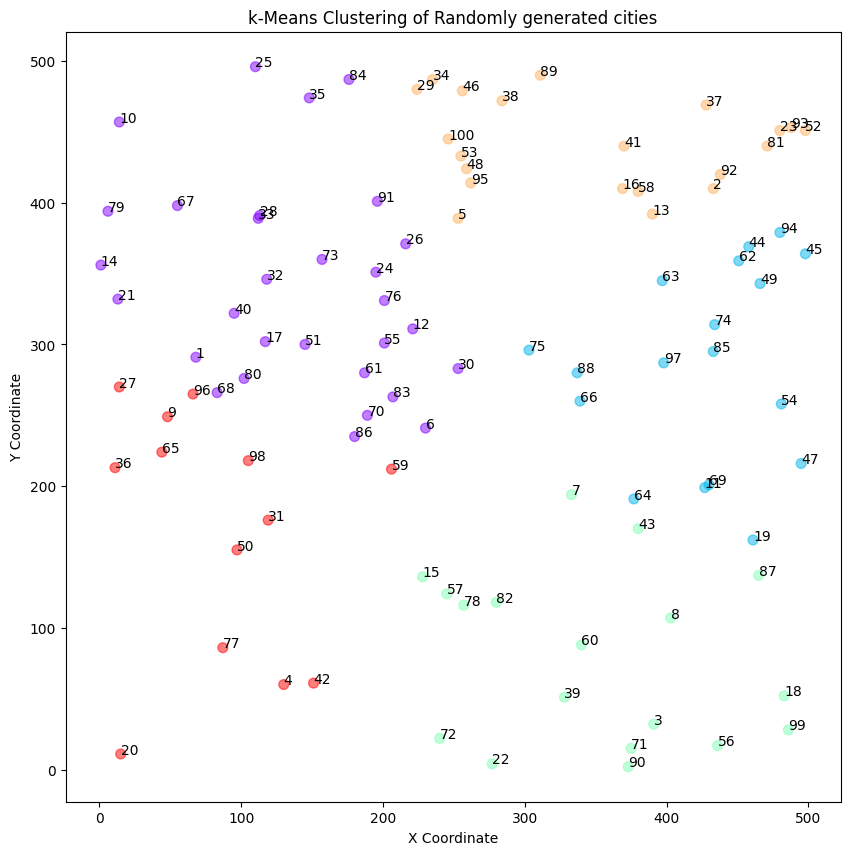

In [5]:
class kMeansClusters:
    def __init__(self, k: int, data: tuple[int, int, int]) -> None:
        self.k = k
        self.data = data
        self.coordinates = np.array([(x, y) for n, x, y in data])
        self.kmeans = KMeans(n_clusters=k, random_state=0)
        self.__fit()

    def __fit(self) -> None:
        self.clusters = self.kmeans.fit_predict(self.coordinates)

    def getClusters(self) -> np.ndarray:
        return self.clusters

    def getCitiesByCluster(self) -> list[list[tuple[int, int, int]]]:
        cities_clusters = [[] for _ in range(self.k)]
        for i in range(self.k):
            for j in range(len(self.clusters)):
                if self.clusters[j] == i:
                    cities_clusters[i].append(self.data[j])
        return cities_clusters


k = 5
k_means = kMeansClusters(k, data.cities)
clusters = k_means.getClusters()
cities_clusters = k_means.getCitiesByCluster()

graph = Graph(data=data.cities, title="k-Means Clustering of Randomly generated cities")
graph.scatterPlot(c=clusters, cmap='rainbow', s=50, alpha=0.5)

## 3. Algorithmes

### 3.1. Choix des algorithmes

Pour résoudre notre problème nous avons choisi les algorithmes suivants :
- Programmation Linéaire
- Algorithme glouton
- Algorithme tabou

### 3.2. Programmation linéaire

Pour résoudre ce problème, nous avons décidé d'utiliser plusieurs méthodes, dont la méthode de résolution linéaire. Pour ce faire, nous avons modéliser le problème sous forme de programme linéaire, où les variables de décisions sont: </br>
$x_ij$: le couple (i, j) représentent l'arrête (i, j)</br>
$u_i$: la varible de "flux", où chaque i représente un sommet, permettant d'éviter des sous-cycles</br>
$c_ij$: le couple (i, j), représentant le poids de l'arrête </br></br>
Les contraintes sont:</br>
- $\sum\limits_{i \in E, i \neq k} x_ik = 1$  $\forall k \in V $</br>
- $\sum\limits_{j \in V, j \neq k} x_kj = 1$  $\forall k \in V $ </br>
- $x_ij \in [{0, 1}]$</br>
- $\forall (i,j) \in E$</br>
- $u_i - u_j + 1 <= (n-1)*(1-x_ij)$ avec n=nombres de noeuds

La fonction Objectif est : </br>
$\sum\limits_{(i,j) \in E} x_ij * c_ij = 1$ </br>

Nous avons décidé d'utiliser les modules gurobipy et pulp pour implémenter cette solution linéaire.</br>
#### Complexité :
Concernant la complexité du programme, le solveur gurobipy et pulp, sont tous les deux des solveurs avec une complexité en temps exponentiel, étant donné que les variables de décisions et les contraintes vont continuer de s'aggrandir avec le nombres d'arrêtes. 

#### Solution :
Puisque nous avons en entrée du programme une liste de sommets et non une liste d'arrêtes, nous allons devoir créer un graphe intermédiaire permettant de faire tourner le programme linéaire. Pour ce faire, nous allons construire un graphe planaire, permettant de relier tous les points de manière logique, comme des villes dans la réalité. 

Restricted license - for non-production use only - expires 2025-11-24
Total distance: 22280.235751622688


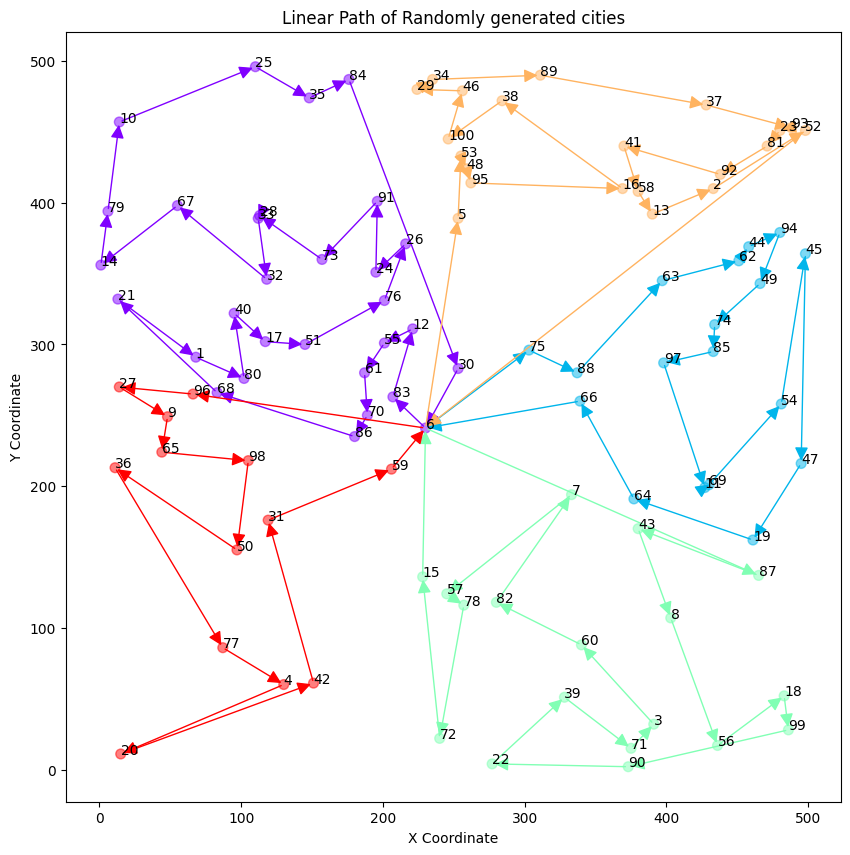

In [6]:
class LinearProgramming():
    def __init__(self, cities: Cities) -> None:
        """
        Initialize the Linear Programming solver.

        :param cities: Instance of the Cities class
        """
        self.cities = cities

    def __getCyclePulp(self, vertexs: list[tuple[int, int, int]], all_edges: list[tuple[int, int]], all_weighed_edges: dict[tuple[int, int], float]) -> list[tuple[int, int, int]]:
        """
        Solve the TSP problem using Pulp.

        :param vertexs: List of all the vertices
        :param all_edges: List of all the edges
        :param all_weighed_edges: Dictionary of all the edges and their weight
        :return: List of vertices representing a cycle
        """
        # List of all the vertexs
        all_vertexs = [i for i in range(len(vertexs))]

        # Decisions variables
        x = pulp.LpVariable.dicts('x', all_edges, cat=pulp.LpBinary)
        u = pulp.LpVariable.dicts('u', all_vertexs, lowBound=1, upBound=len(all_vertexs), cat=pulp.LpInteger)

        # Model creation
        model = pulp.LpProblem("TSP", pulp.LpMinimize)

        # Objective function (we multiply the edges by their weight)
        model += pulp.lpSum(x[i, j]*all_weighed_edges[i, j] for (i, j) in all_edges)

        # Degree constraints
        for current_vertex in all_vertexs:
            # We need to have exactly 1 outgoing edge
            model += pulp.lpSum(x[i, k] for (i, k) in all_edges if i==current_vertex) == 1
            # We need to have exactly 1 incoming edge
            model += pulp.lpSum(x[i, k] for (k, i) in all_edges if k==current_vertex) == 1

        # SubTour elimination
        n = len(all_vertexs)
        for (i, j) in all_edges:
            # Avoid defining a constraint for the starting vertex
            if i != 0 and j != 0:
                # This constraint eliminates SubTour
                model += u[i] - u[j] + n * x[i, j] <= n - 1, f"SEC_{i}_{j}"

        # Fix the starting vertex
        model += u[0] == 1, "Start"

        # Solve the model
        solver = pulp.PULP_CBC_CMD(msg=0)
        model.solve(solver)

        # We store all the chosen edges
        result = {}
        for (i, j) in all_edges:
            if pulp.value(x[i, j]) == 1:
                result[i] = (i, j)

        # We return the list of edges in the format: [(vertex_i, position_x_i, position_y_i)]
        final_result = []
        next_visited = 0
        (i, j) = (0, 0)
        for t in range (len(result)+1):
            (i, j) = result[next_visited]
            final_result.append((i+1, vertexs[i][1], vertexs[i][2]))
            next_visited = j
        return final_result, pulp.value(model.objective)


    def __getCycleGurobi(self, vertexs: list[tuple[int, int, int]], all_edges: list[tuple[int, int]], all_weighed_edges: dict[tuple[int, int], float]) -> list[tuple[int, int, int]]:
        """
        Solve the TSP problem using Gurobi

        :param vertexs: List of all the vertices
        :param all_edges: List of all the edges
        :param all_weighed_edges: Dictionary of all the edges and their weight
        :return: List of vertices representing a cycle
        """
        # List of all the vertexs
        all_vertex  = [i for i in range(len(vertexs))]

        # Decisions variables
        model = gp.Model("TSP")
        model.setParam('OutputFlag', 0)
        x = model.addVars(all_edges, vtype=GRB.BINARY, name="x")
        u = model.addVars(all_vertex, lb=1, ub=len(all_vertex), vtype=GRB.INTEGER, name='u')

        # Objective function (we multiply the edges by their weight)
        model.setObjective(gp.quicksum(x[i, j]*all_weighed_edges[i, j] for (i, j) in all_edges), GRB.MINIMIZE)

        # Degree constraints
        for sommet in all_vertex:
            # We need to have exactly 1 outgoing edge
            model.addConstr(gp.quicksum(x[i, k] for (i, k) in all_edges if i==sommet) == 1)
            # We need to have exactly 1 incoming edge
            model.addConstr(gp.quicksum(x[i, k] for (k, i) in all_edges if k==sommet) == 1)

        # SubTour elimination
        n = len(all_vertex)
        for (i, j) in all_edges:
            # Avoid defining a constraint for the starting vertex
            if i != 0 and j != 0:
                model.addConstr(u[i] - u[j] + n * x[i, j] <= n - 1, f"SEC_{i}_{j}")
        model.addConstr(u[0] == 1, "Start")
        model.optimize()

        # We store all the chosen edges
        result = {}
        for (i, j) in all_edges:
            if x[i, j].X > 0.5:
                result[i] = (i, j)

        # We return the list of edges in the format: [(vertex_i, position_x_i, position_y_i)]
        final_result = []
        next_visited = 0
        (i, j) = (0, 0)
        for t in range (len(result)+1):
            (i, j) = result[next_visited]
            final_result.append((i+1, vertexs[i][1], vertexs[i][2]))
            next_visited = j
        return final_result, model.ObjVal


    def __createConnexeGraph(self, all_cities: list[tuple[int, int, int]]) -> list[tuple[int, int]]:
        """
        Create a connexe graph using Delaunay triangulation.

        :param all_cities: List of all the vertices
        :return: List of edges
        """
        # List of positions corresponding to the cities
        points = []
        for i in all_cities:
            points.append((i[1], i[2]))

        # Delaunay triangulation
        tri = Delaunay(points)
        G = nx.Graph()

        # Add vertex to the graph
        for i, point in enumerate(points):
            G.add_node(i, pos=(point[0], point[1]))

        # Add edges to the graph based on the Delaunay triangulation
        for simplex in tri.simplices:
            for i in range(3):
                for j in range(i+1, 3):
                    G.add_edge(simplex[i], simplex[j])

        # Return all the edges
        result = []
        for i in G.edges():
            result.append(i)
            result.append((i[1], i[0]))
        return result


    def __startGettingBestChemin(self, nodes: list[tuple[int, int, int]], choice_solve: str="GUROBIPY") -> tuple[list[tuple[int, int, int]], float]:
        """
        Start getting the best path.

        :param nodes: List of all the vertices
        :param choice_solve: String to know which solver to use (PULP, GUROBIPY)
        :return: List of vertices representing a cycle, total distance
        """
        all_edges = []
        weighed_edges = {}
        # Create a connexe graph
        all_edges = self.__createConnexeGraph(nodes)

        # Create weighed edges
        for (i, j) in all_edges:
            weighed_edges[(i, j)] = self.cities.calculateDistance(i, j)

        if choice_solve == "GUROBIPY":
            best_cycle, value = self.__getCycleGurobi(nodes, all_edges, weighed_edges)
        else:
            best_cycle, value = self.__getCyclePulp(nodes, all_edges, weighed_edges)
        return best_cycle, value

    def processClusters(self, cities_clusters: list[list[tuple[int, int, int]]], center_city: tuple[int, int, int]) -> tuple[list[tuple[int, int, int]], float]:
        """
        Process the clusters.

        :param cities_clusters: List of all the clusters
        :return: List of vertices representing a cycle, total distance
        """
        cluster_linear_path = []
        total_distance = 0
        for cluster_idx, cluster in enumerate(cities_clusters):
            if center_city in cluster:
                cluster.remove(center_city)
            cluster.append(center_city)
            chemin, value = self.__startGettingBestChemin(cluster, "GUROBIPY")
            total_distance += value
            cluster_linear_path.append(chemin)
        return cluster_linear_path, total_distance


lp_solver = LinearProgramming(data)
cluster_linear_path, total_distance = lp_solver.processClusters(cities_clusters, center_city)

print(f"Total distance: {total_distance}")

graph = Graph(data=data.cities, title="Linear Path of Randomly generated cities")
graph.scatterPlot(c=clusters, cmap='rainbow', s=50, alpha=0.5, arrow=cluster_linear_path)

### 3.3. Algorithme glouton (greedy)

L'algorithme glouton résout les problèmes en faisant des choix locaux optimaux à chaque étape pour espérer atteindre une solution globale optimale. Le code ci-dessous montre cette approche : on commence par une ville de départ, on trouve la ville non visitée la plus proche, la visite, et répète ce processus jusqu'à ce que toutes les villes soient visitées, puis on retourne à la ville de départ pour compléter le cycle. Ce processus est appliqué à des clusters de villes, incluant une ville centrale dans chaque cluster.

Schéma exemple de Greedy :

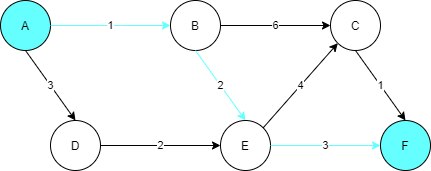

Total distance: 5856.968496941388


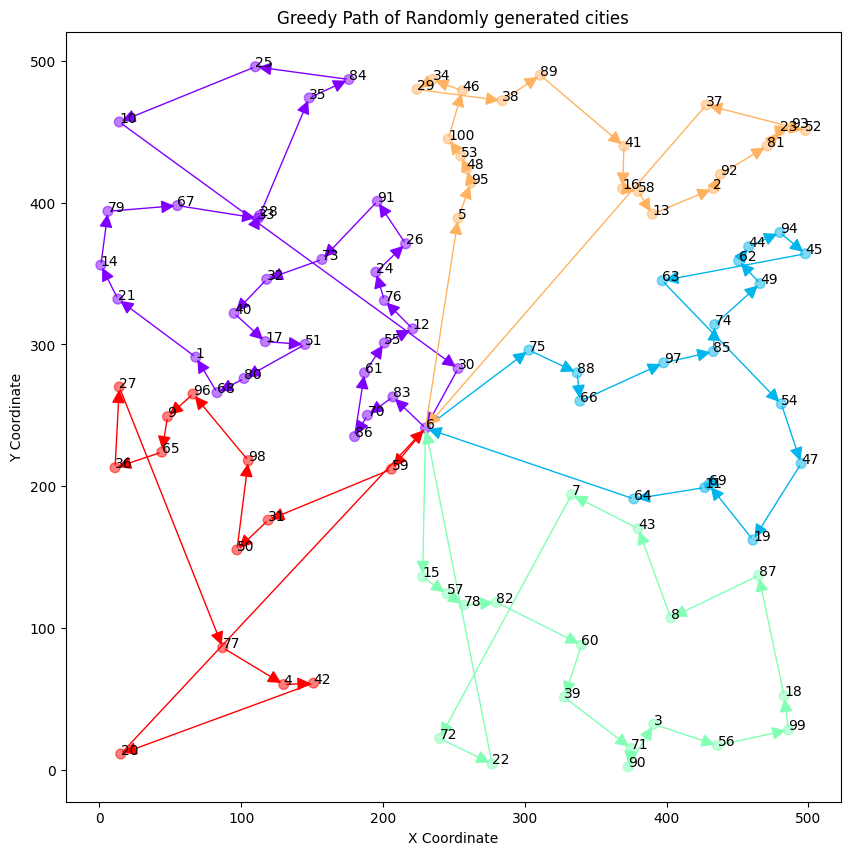

In [7]:
class Greedy:
    def __init__(self, cities: Cities) -> None:
        """
        Initialize the Greedy object with city information.

        :param cities: Instance containing city information and methods to calculate distances.
        """
        self.cities = cities

    def __greedyPath(self, nodes: list[tuple[str, int, int]], start: str) -> tuple[list[tuple[str, int, int]], float]:
        """
        Calculate the path using a greedy approach starting from a given point.

        :param nodes: List of tuples representing cities in the form (name, x-coordinate, y-coordinate).
        :param start: Starting city.
        :return: Tuple containing the calculated path as a list and the total distance traveled.
        """
        # Convert nodes to a dictionary for quick access
        self.nodes = {node[0]: (node[1], node[2]) for node in nodes}
        visited = set()
        unvisited = set(self.nodes.keys())
        path = [(start, *self.nodes[start])]
        current = start
        visited.add(current)
        unvisited.remove(current)
        total_distance = 0

        while unvisited:
            next_node = None
            min_distance = float('inf')
            # Find the closest unvisited city
            for node in unvisited:
                distance = self.cities.calculateDistance(current, node)
                if distance < min_distance:
                    min_distance = distance
                    next_node = node
            total_distance += min_distance
            current = next_node
            path.append((current, *self.nodes[current]))
            visited.add(current)
            unvisited.remove(current)

        # Return to the starting city to complete the cycle
        path.append((start, *self.nodes[start]))
        total_distance += self.cities.calculateDistance(current, start)
        return path, total_distance

    def processClusters(self, cities_clusters: list[list[tuple[str, int, int]]], center_city: str) -> tuple[list[list[tuple[str, int, int]]], float]:
        """
        Process clusters of cities and calculate the greedy path for each cluster.

        :param cities_clusters: List of clusters, each cluster being a list of tuples (name, x-coordinate, y-coordinate).
        :param center_city: The central city to include in each cluster.
        :return: Tuple containing the greedy paths for each cluster and the total distance traveled.
        """
        cluster_greedy_path = []
        total_distance = 0
        for cluster_idx, cluster in enumerate(cities_clusters):
            if center_city in cluster:
                cluster.remove(center_city)
            cluster.append(center_city)
            path, distance = self.__greedyPath(cluster, cluster[-1][0])
            cluster_greedy_path.append(path)
            total_distance += distance
        return cluster_greedy_path, total_distance

# Usage
greedy_solver = Greedy(data)
cluster_greedy_paths, total_distance = greedy_solver.processClusters(cities_clusters, center_city)

print(f"Total distance: {total_distance}")

graph = Graph(data=data.cities, title="Greedy Path of Randomly generated cities")
graph.scatterPlot(c=clusters, cmap='rainbow', s=50, alpha=0.5, arrow=cluster_greedy_paths)

### 3.4. Algorithme Tabou
Pour résoudre ce problème, nous pouvons utiliser une méthode de recherche avec liste tabou. Cette méthode est métaheuristique et permet d'avoir de bons résultats en temps correct. Cette méthode permet de visiter les noeuds voisins d'un chemin, permettant de chercher si il existe un voisin avec de meilleurs résultat que le chemin actuel, permettant de progresser vers un optimum global.

#### Complexité :
Pour la complexité de ce programme, nous avons 3 variables d'entrée qui enfluent la complexité:
- ``max_iteration``, le nombre maximum d'itérations
- ``k``, le nombre de voisins générés à chaque itération.
- ``n``, le nombre de ville

La complexité sera donc : ``O(max_iteration * k * n)``. La complexité est donc polynomiale.

#### Solution :
Cette solution pemet d'obtenir de relativement bon résultats, en modifiant les paramètres. Plus on augmentera me nombre de voisins générés et le nombre maximum d'itérations, meilleurs seront les résultats. Mais si on doit grandement augmenter le nombre de ville, il faudra veiller a réduire ces paramètres pour obtenir une solution en un temps correct.

Total distance: 6155.097794450841


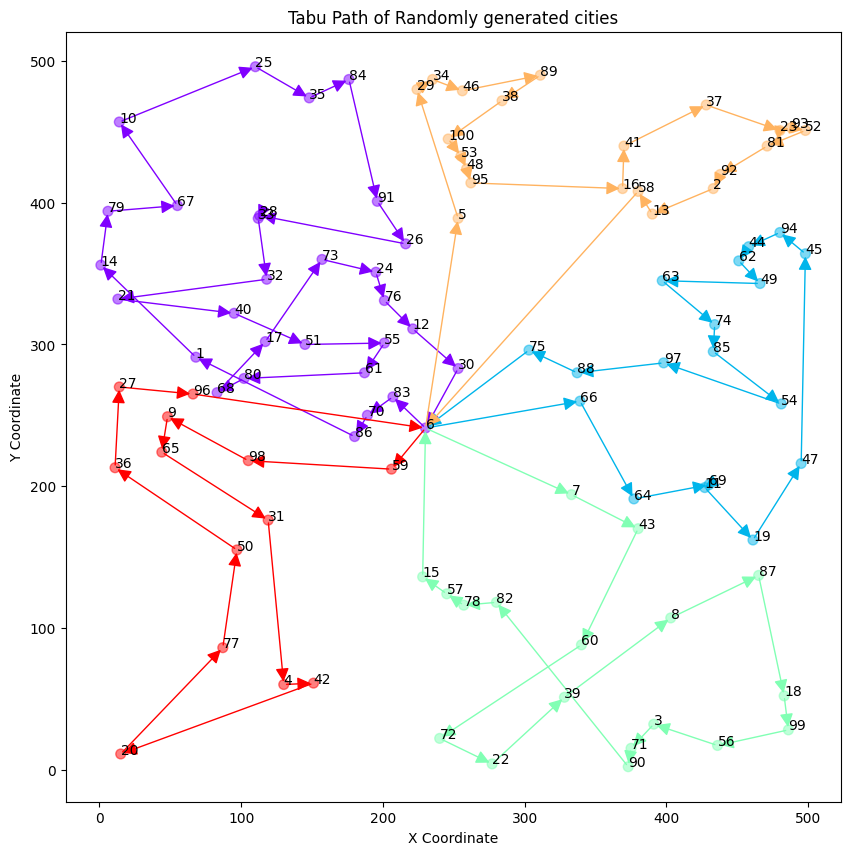

In [8]:
class Tabu():
    def __init__(self, cities: Cities) -> None:
        """
        Initialize the Tabu object with city information.

        :param cities: Instance containing city information and methods to calculate distances.
        """
        self.cities = cities

    def tabuList(self, cities, k=500, max_iteration=200, max_tabou=10):
        """
        Return the best cycle found wit the vertex

        :param cities: List of vertex, representing the cities
        :param k: The number of k neighbors we visit
        :param max_iteration: the maximum iterations we do before exiting the loop
        :param max_tabou: The maximum number of element we keep at the tabu list at the same time
        :return: List of Tuple containing the best path and the distance traveled.
        """
        vertexs = []
        all_heighed_vertex = {}
        for i in range (len(cities)):
            for j in range (len(cities)):
                if i == j:
                    continue
                all_heighed_vertex[(cities[i][0]-1, cities[j][0]-1)] = data.calculateDistance(cities[i][0], cities[j][0])
            vertexs.append(cities[i][0]-1)

        vertexs.append(vertexs[0])

        tabous_list = set()
        current_list = copy.deepcopy(vertexs)
        iteration = 0

        global_min = self.calcul_cout(vertexs, all_heighed_vertex)

        while iteration < max_iteration:
            if len(current_list) == 3:
                break
            # neighbors are calculated by swapping 2 vertex to get of new cycle. we get k neighbors.
            all_neighbors = self.get_neighbors(current_list, k)
            local_min = float('inf')
            local_neighbor = []
            # we visit every neighbors in the current cycle
            for neighbor in all_neighbors:
                cout = self.calcul_cout(neighbor, all_heighed_vertex)
                # pour la premiere ittération
                if cout <= local_min:
                    if tuple(neighbor) in tabous_list and local_min >= global_min:
                        continue
                    local_min = cout
                    local_neighbor = neighbor


            # if local minimum is greater than the global minimum, we found the best cycle
            if local_min < global_min:
                if len(tabous_list) >= max_tabou:
                    tabous_list.pop()
                tabous_list.add(tuple(current_list))
                current_list = local_neighbor
                global_min = local_min
            else:
                break

            iteration += 1

        # we transform data to correct output
        final_result = []
        for vertex in current_list:
            for citie in cities:
                if citie[0] == (vertex+1):
                    final_result.append(citie)
        #print("final result = ", final_result)
        return final_result, global_min


    def calcul_cout(self, vertexs, weighed_edges):
        cout = 0
        for i in range (len(vertexs)-1):
            cout += weighed_edges[(vertexs[i], vertexs[i+1])]
        return cout


    def get_neighbors(self, lst, k):
        # Fixer le premier et le dernier élément
        first, last = lst[0], lst[-1]
        middle = lst[1:-1]

        permutations = []

        for _ in range(k):
            # Créer une copie de la liste du milieu
            permuted_middle = middle[:]

            # Choisir aléatoirement deux indices différents à permuter
            i, j = random.sample(range(len(permuted_middle)), 2)

            # Permuter les éléments
            permuted_middle[i], permuted_middle[j] = permuted_middle[j], permuted_middle[i]

            # Reconstituer la liste complète
            new_permutation = [first] + permuted_middle + [last]
            permutations.append(new_permutation)

        return permutations

    def processClusters(self, cities_clusters: list[list[tuple[int, int, int]]], center_city: tuple[int, int, int], k=500, max_iteration=200, max_tabu=10) -> tuple[list[list[tuple[str, int, int]]], float]:
        """
        Process the clusters.

        :param cities_clusters: List of all the clusters
        :return: List of vertices representing a cycle, total distance
        """
        cluster_linear_path = []
        total_distance = 0
        for cluster_idx, cluster in enumerate(cities_clusters):
            if center_city in cluster:
                cluster.remove(center_city)
            cluster.append(center_city)
            chemin, value = self.tabuList(cluster, k, max_iteration, max_tabu)
            total_distance += value
            cluster_linear_path.append(chemin)
        return cluster_linear_path, total_distance

tabu = Tabu(data)
cluster_tabou_paths, total_distance = tabu.processClusters(cities_clusters, center_city)

print(f"Total distance: {total_distance}")

graph = Graph(data=data.cities, title="Tabu Path of Randomly generated cities")
graph.scatterPlot(c=clusters, cmap='rainbow', s=50, alpha=0.5, arrow=cluster_tabou_paths)

## 4. Étude expérimentale

Une fois nos algorithmes mis en place, nous sommes passés à l'étude de nos résultats. Pour cela, nous réalisons deux tests :
- Évolution du temps de calcul en fonction du nombre de villes et de clusters
- Évolution de la distance parcourue en fonction du nombre de villes et de clusters

Les deux tests sont réalisés par la fonction ``soluStats`` qui affiche en sortie deux graphiques représentant les deux éléments cités précédemment.<br>
Ces graphiques vont nous permettre de déterminer quel algorithme est le plus performant dans notre cas.

In [9]:
def solutionStats(cls, title: str, nb_iteration: int, taille_min: int, taille_max: int, taille_step: int, k_values: int) -> None:
    """
    Display the evolution of the duration and the distance in function of the size of the graph and the k value

    :param cls: Class to use
    :param title: Title of the graph
    :param nb_iteration: Number of iterations
    :param taille_min: Minimum size of the graph
    :param taille_max: Maximum size of the graph
    :param taille_step: Step between each size
    :param k_values: List of k values
    """
    # Create an array to store durations in function of the size of the graph and the k value
    durees = np.zeros((len(k_values), (taille_max - taille_min) // taille_step))
    distances = np.zeros((len(k_values), (taille_max - taille_min) // taille_step))

    # Create a progress bar
    nb_tests = ((taille_max - taille_min) / taille_step) * nb_iteration * len(k_values)
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)

    for taille in range(taille_min, taille_max, taille_step):
        duree_moy   = 0.0
        distance_moy = 0.0
        for k in k_values:
            for i in range(nb_iteration):
                algo_data = Cities(taille, x_range, y_range)
                center_city = algo_data.getCenterCity()
                k_means = kMeansClusters(k, algo_data.cities)
                cities_clusters = k_means.getCitiesByCluster()
                algo_solver = cls(algo_data)
                start = time.time()
                cluster_algo_paths, total_distance = algo_solver.processClusters(cities_clusters, center_city)
                stop = time.time()
                duree = stop - start

                duree_moy += duree
                distance_moy += total_distance
                bar.value += 1

            durees[k_values.index(k)][(taille - taille_min) // taille_step] = duree_moy / nb_iteration
            distances[k_values.index(k)][(taille - taille_min) // taille_step] = distance_moy / nb_iteration
    # Close the progress bar
    bar.close()
    # on règle l'affichage des courbes
    tailles = [x for x in range(taille_min, taille_max, taille_step)]
    plt.figure(figsize=(20,10))

    plt.xlabel('Taille du graphe (nombre de sommets)')
    plt.xticks(ticks=tailles) # valeurs affichées sur l'axe X
    plt.ylabel('Temps de calcul (en s)')
    plt.title(title)
    for i in range(len(k_values)):
        plt.plot(tailles, durees[i], label=f'k={k_values[i]}')

    # on affiche
    plt.legend()
    plt.show()

    plt.figure(figsize=(20,10))

    plt.xlabel('Taille du graphe (nombre de sommets)')
    plt.xticks(ticks=tailles) # valeurs affichées sur l'axe X
    plt.ylabel('Distance parcourue')
    plt.title(title)
    for i in range(len(k_values)):
        plt.plot(tailles, distances[i], label=f'k={k_values[i]}')

    # on affiche
    plt.legend()
    plt.show()


def solutionStats_tabu(cls, title: str, nb_iteration, taille_min, taille_max, taille_step, k_values, k_tabu, k_tabu_step) -> None:
    # Create an array to store durations in function of the size of the graph and the k value
    durees = np.zeros((len(k_values), (taille_max - taille_min) // taille_step))
    distances = np.zeros((len(k_values), (taille_max - taille_min) // taille_step))

    # on affiche la barre de progression
    nb_tests = ((taille_max - taille_min) / taille_step) * nb_iteration * len(k_values)
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)

    for taille in range(taille_min, taille_max, taille_step):
        duree_moy   = 0.0
        distance_moy = 0.0
        k_tabu -= k_tabu_step
        print("new taille = ", taille, " new k = ", k_tabu)
        for k in k_values:
            for i in range(nb_iteration):
                algo_data = Cities(taille, x_range, y_range)
                center_city = algo_data.getCenterCity()
                k_means = kMeansClusters(k, algo_data.cities)
                cities_clusters = k_means.getCitiesByCluster()
                algo_solver = cls(algo_data)
                start = time.time()
                cluster_algo_paths, total_distance = algo_solver.processClusters(cities_clusters, center_city, k_tabu, 200, 2)
                stop = time.time()
                duree = stop - start

                duree_moy += duree
                distance_moy += total_distance
                bar.value += 1

            durees[k_values.index(k)][(taille - taille_min) // taille_step] = duree_moy / nb_iteration
            distances[k_values.index(k)][(taille - taille_min) // taille_step] = distance_moy / nb_iteration
    # on cache la barre de progression
    bar.close()

    # on règle l'affichage des courbes
    tailles = [x for x in range(taille_min, taille_max, taille_step)]
    plt.figure(figsize=(20,10))

    plt.xlabel('Taille du graphe (nombre de sommets)')
    plt.xticks(ticks=tailles) # valeurs affichées sur l'axe X
    plt.ylabel('Temps de calcul (en s)')
    plt.title(title)
    for i in range(len(k_values)):
        plt.plot(tailles, durees[i], label=f'k={k_values[i]}')

    # on affiche
    plt.legend()
    plt.show()

    plt.figure(figsize=(20,10))

    plt.xlabel('Taille du graphe (nombre de sommets)')
    plt.xticks(ticks=tailles) # valeurs affichées sur l'axe X
    plt.ylabel('Distance parcourue')
    plt.title(title)
    for i in range(len(k_values)):
        plt.plot(tailles, distances[i], label=f'k={k_values[i]}')

    # on affiche
    plt.legend()
    plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=280)

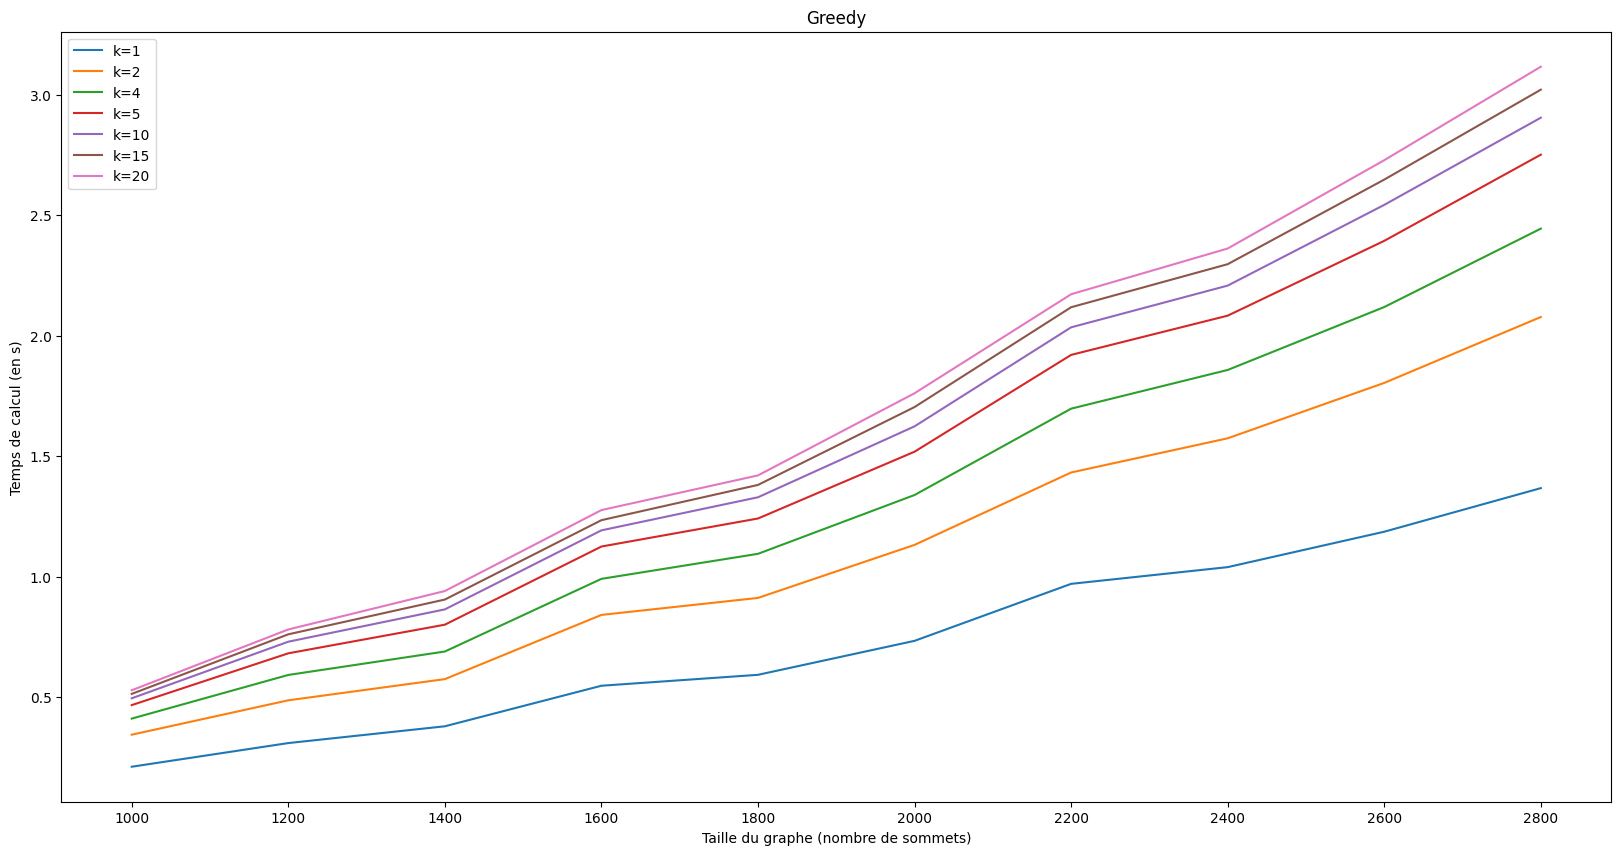

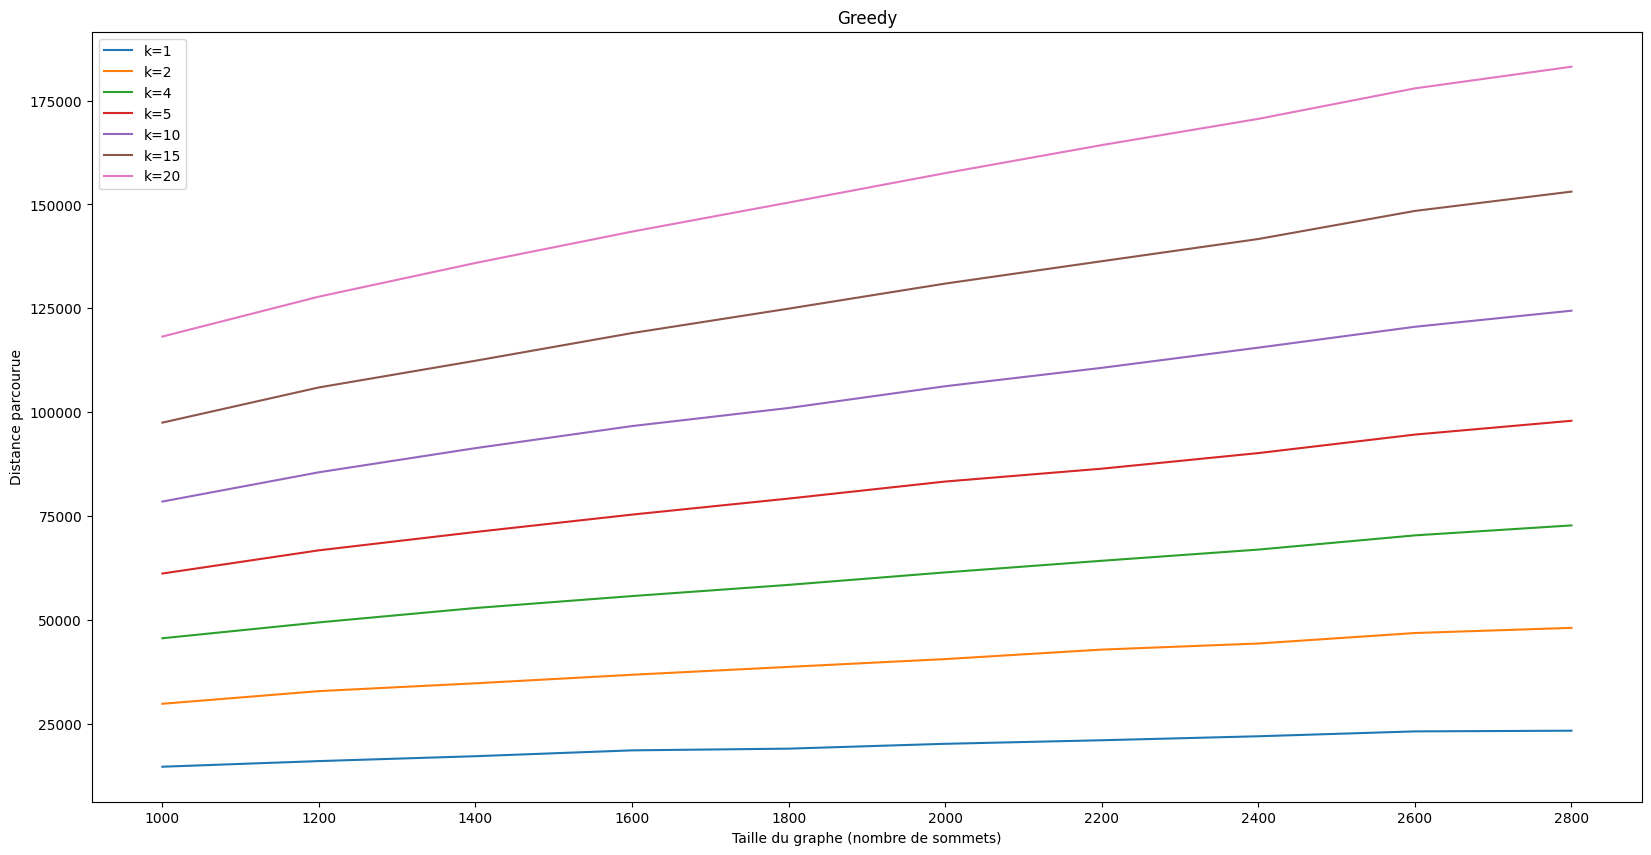

In [10]:
nb_iteration = 4
taille_min   = 1000
taille_max   = 3000
taille_step  = 200
k_values     = [1, 2, 4, 5, 10, 15, 20]

solutionStats(Greedy, "Greedy", nb_iteration, taille_min, taille_max, taille_step, k_values)

IntProgress(value=0, layout=Layout(width='100%'), max=9)

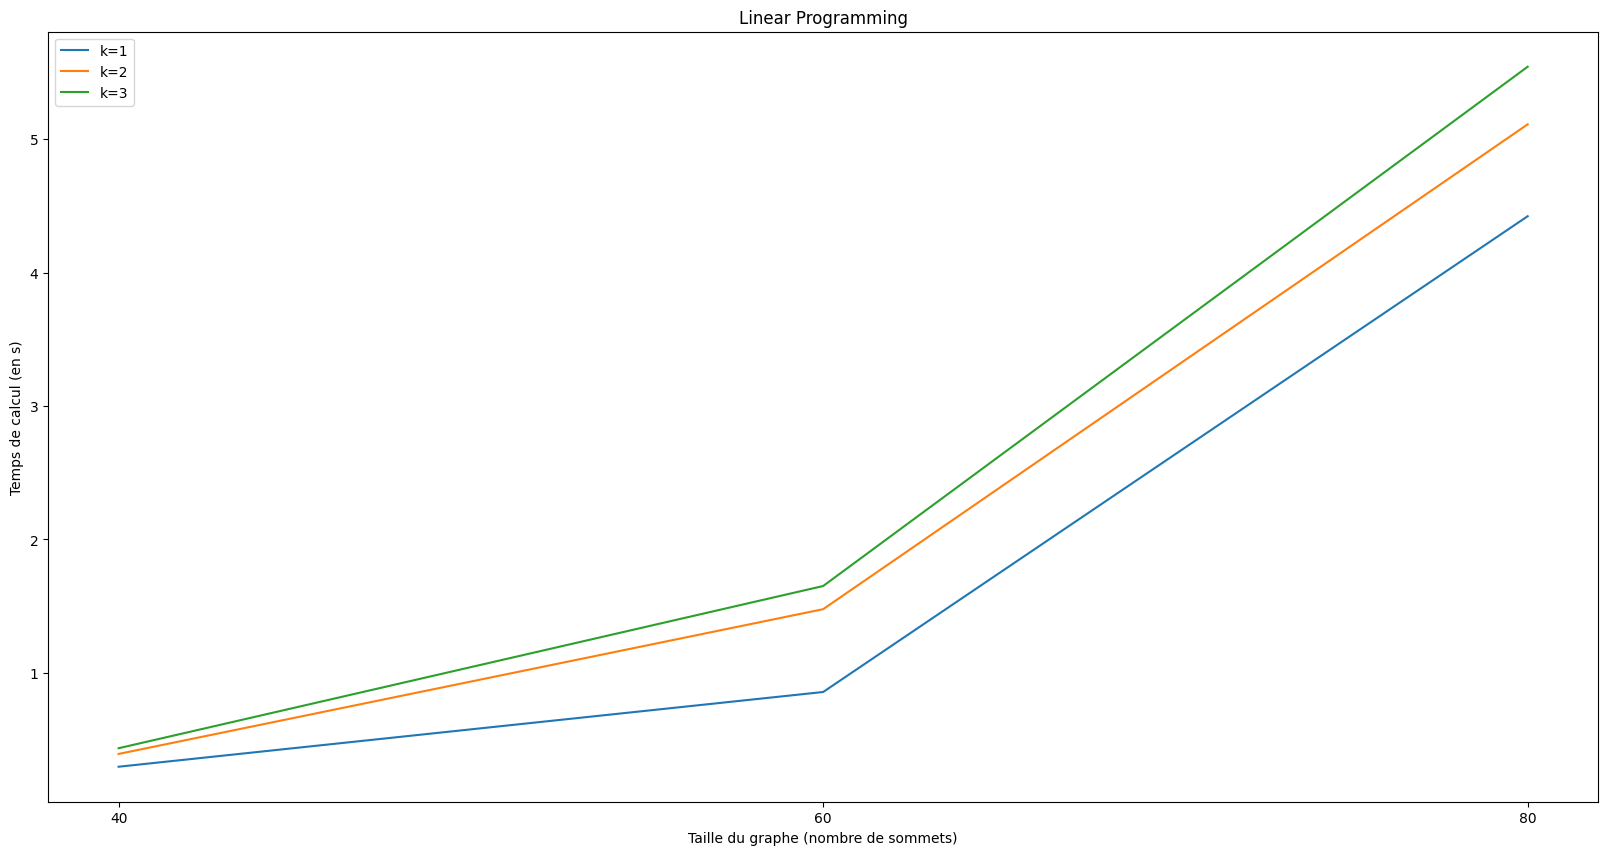

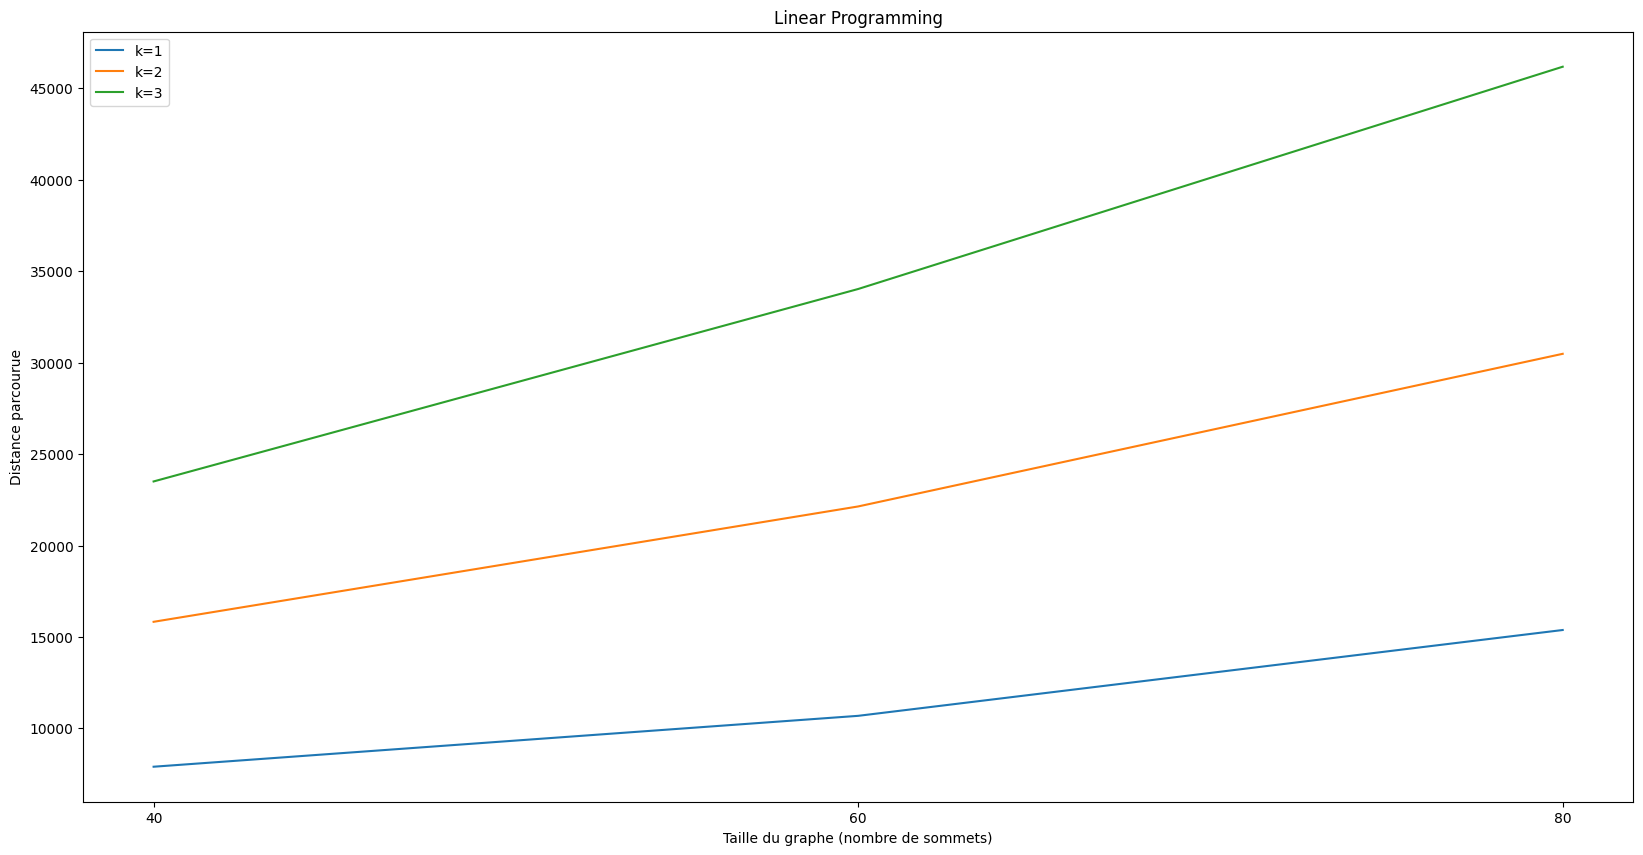

In [13]:
nb_iteration = 1
taille_min   = 40
taille_max   = 100
taille_step  = 20
k_values     = [1, 2, 3]

solutionStats(LinearProgramming, "Linear Programming", nb_iteration, taille_min, taille_max, taille_step, k_values)

IntProgress(value=0, layout=Layout(width='100%'), max=35)

new taille =  500  new k =  90
new taille =  700  new k =  80
new taille =  900  new k =  70
new taille =  1100  new k =  60
new taille =  1300  new k =  50


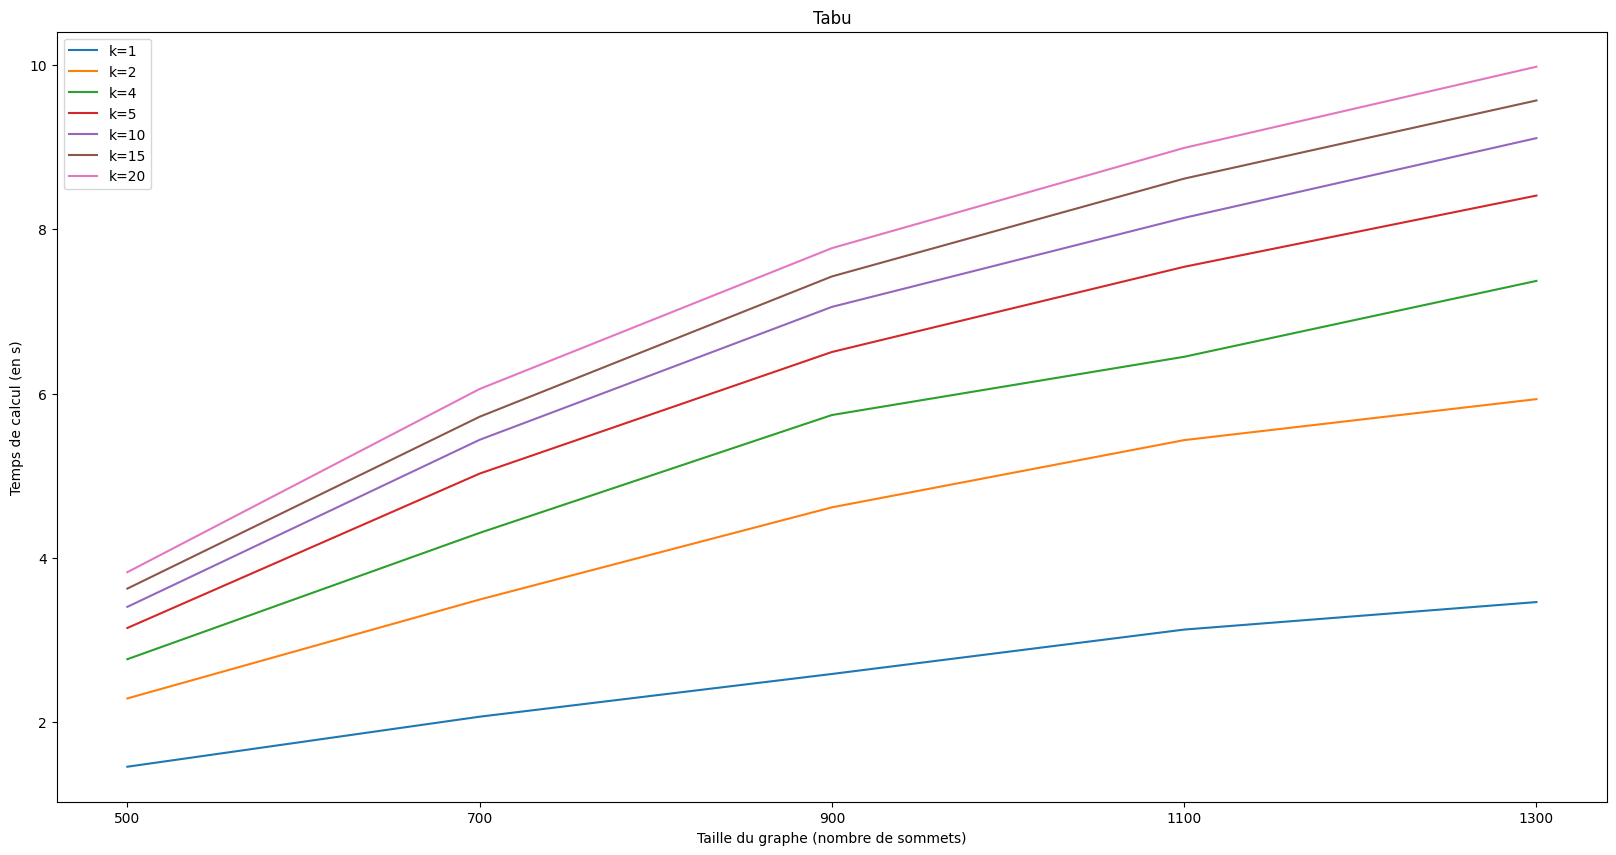

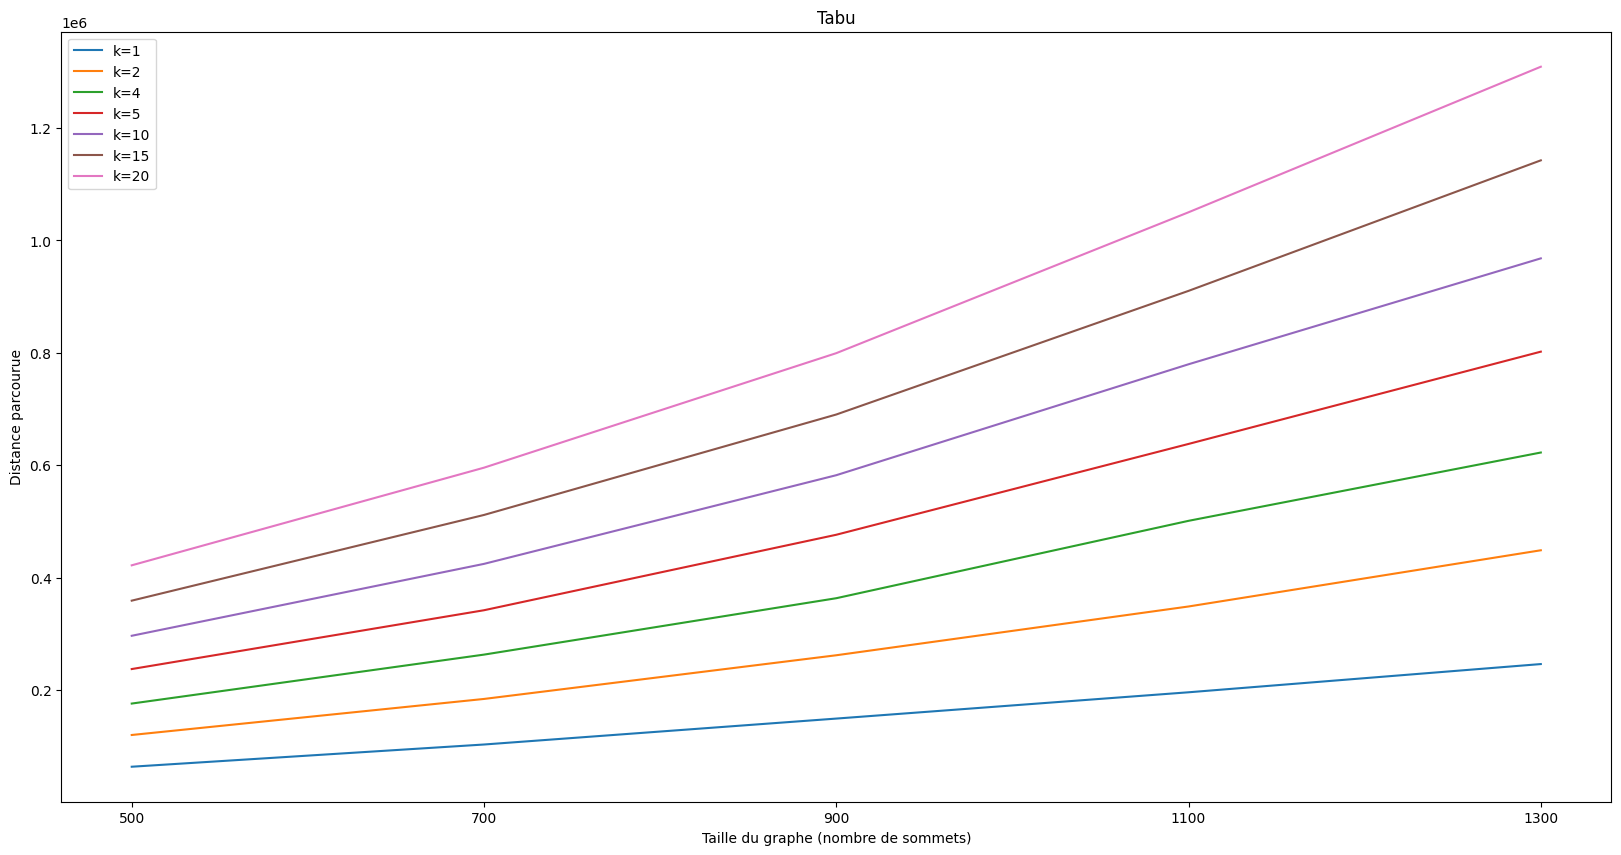

In [16]:
nb_iteration = 1
taille_min   = 500
taille_max   = 1500
taille_step  = 200
k_values     = [1, 2, 4, 5, 10, 15, 20]

k_tabu = 100
k_tabu_step = 10

solutionStats_tabu(Tabu, "Tabu", nb_iteration, taille_min, taille_max, taille_step, k_values, k_tabu, k_tabu_step)

## 5. Conclusion

D'après les résultats obtenus, nous pouvons dire que la méthode greedy semble être la meilleure approche. En effet, comme nous avons basé notre implémentation sur la construction d'un graphe à partir des sommets, la méthode greedy est parfaitement adaptée. Cette méthode permet de chercher la ville la plus proche de celle où nous nous trouvons actuellement. </br>

La méthode de recherche tabou donne également de bons résultats dans un temps raisonnable. En tant que méthode méta-heuristique, elle offre des solutions satisfaisantes et efficaces.</br>

En revanche, la méthode de résolution linéaire donne les moins bons résultats parmi les trois. Cela s'explique par la lenteur de l'exécution du programme pour un grand nombre de villes, ainsi que par la nécessité de construire un graphe planaire au préalable pour pouvoir exécuter l'algorithme. Néanmoins, pour un nombre réduit de villes, cette méthode offre une vision plus réaliste, car le graphe planaire qu'elle résout représente de manière plus fidèle la réalité. </br>

En résumé, pour un petit nombre de villes, il est recommandé d'utiliser la résolution linéaire pour obtenir des distances plus réalistes. Ensuite, pour des résultats plus rapides, bien que légèrement moins précis, il est préférable d'opter pour la méthode de recherche tabou ou greedy.